Python was not able to load the fast fortran assembly routines.

Python was not able to load the fast fortran material routines.

Warning! Using mpiexec in global path
Warning! Using python in global path


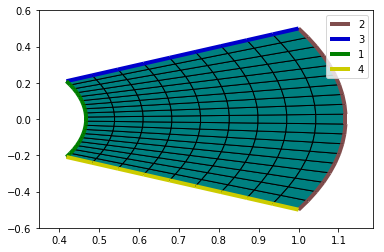

In [1]:
import amfe
import matplotlib.pyplot as plt
import pandas as pd
import scipy.linalg as linalg
from scipy.sparse import linalg as splinalg
import numpy as np
import copy

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
#%matplotlib notebook

mshfile = amfe.amfe_dir('meshes/test_meshes/ring_connection.msh')



m = amfe.Mesh()
m.import_msh(mshfile)



amfe.plot_mesh(m)
plt.show()

In [2]:
my_comp = amfe.CraigBamptonComponent()
my_comp.set_mesh_obj(m)

my_material = amfe.KirchhoffMaterial(E=210E9, nu=0.3, rho=7.86E3, plane_stress=True, thickness=1.0)
my_comp.set_domain(6,my_material)


K, f = my_comp.assembly_class.assemble_k_and_f()
K_, f = my_comp.assembly_class.assemble_k_and_f_neumann()
M = my_comp.assembly_class.assemble_m()


Preallocating the stiffness matrix
Done preallocating stiffness matrix with 171 elements and 400 dofs.
Time taken for preallocation: 0.00 seconds.


C:\Users\ndcsi\.conda\envs\ndcsi\lib\site-packages\scipy\sparse\compressed.py:774: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


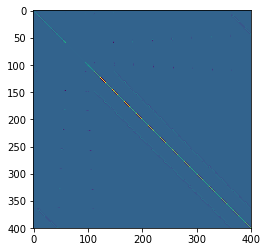

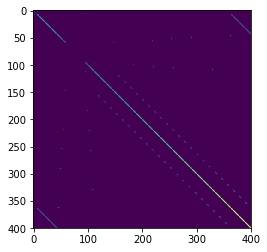

In [3]:
dirsub = m.get_submesh('phys_group', 1)
dirsub_low = m.get_submesh('phys_group', 3)
dirsub_high = m.get_submesh('phys_group', 4)

id_matrix = my_comp.assembly_class.id_matrix

dir_dofs = amfe.get_dirichlet_dofs(dirsub, direction ='xy', id_matrix=id_matrix)
cylic_dofs_low = amfe.get_dirichlet_dofs(dirsub_low, direction ='xy', id_matrix=id_matrix)
cylic_dofs_high = amfe.get_dirichlet_dofs(dirsub_high, direction ='xy', id_matrix=id_matrix)

# remove Dirichle dofs at cyclic dofs 
dir_dofs = list(set(dir_dofs).difference(cylic_dofs_low))
dir_dofs = list(set(dir_dofs).difference(cylic_dofs_high))

K, M, f = my_comp.insert_dirichlet_boundary_cond(K,M,f,dir_dofs)



plt.imshow(K.todense())
plt.show()

plt.imshow(M.todense())
plt.show()



The K, M and f are ordered according its original dofs order


C:\Users\ndcsi\.conda\envs\ndcsi\lib\site-packages\scipy\sparse\compressed.py:774: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


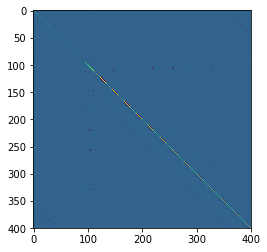

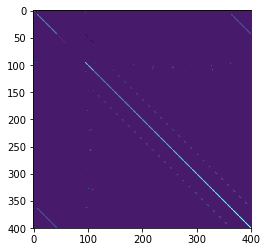

In [4]:
K_mod, M_mod, f_mod = my_comp.insert_cyclic_symm_boundary_cond(K, M, f, low_dofs = cylic_dofs_low , high_dofs = cylic_dofs_high , theta = 0.0)    


plt.imshow(K_mod.todense())
plt.show()

plt.imshow(M_mod.todense())
plt.show()





returning reduced right side, please umpack 5 elementes


C:\Users\ndcsi\.conda\envs\ndcsi\lib\site-packages\scipy\sparse\compressed.py:774: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


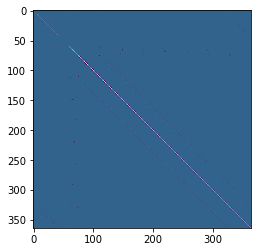

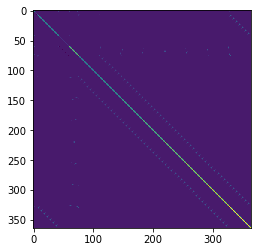

In [5]:
Kii, S, S_inv, T, fi = my_comp.create_selection_operator(dir_dofs, K_mod, f_mod, remove = True)
Mii, Sm, Sm_inv, Tm = my_comp.create_selection_operator(dir_dofs, M_mod, remove = True)


plt.imshow(Kii.todense())
plt.show()

plt.imshow(Mii.T.todense())
plt.show()

In [6]:
num_of_modes = 30
omega, V_dynamic = splinalg.eigs(Kii, k=num_of_modes, M = Mii, which='SM')


V_dynamic = np.real(V_dynamic)
# baking to Augmented System
aug_mode_shapes = []
for i in range(num_of_modes):
    u_global = T(V_dynamic [:,i])
    u_dir = u_global[dir_dofs]
    if abs(u_dir).max()>0.0:
        raise('Error going back to Augmented system')
    aug_mode_shapes.append(u_global)

aug_mode_shapes = np.array(aug_mode_shapes)

In [7]:
# baking to Augmented System
aug_mode_shapes = []
for i in range(num_of_modes):
    aug_mode_shapes.append(T(V_dynamic [:,i]))

aug_mode_shapes = np.array(aug_mode_shapes)

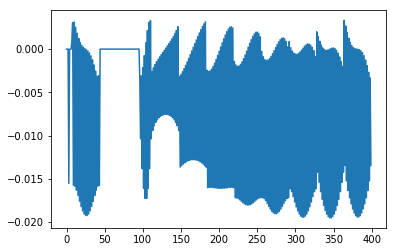

In [8]:
plt.plot(aug_mode_shapes[1])
plt.show()

In [9]:
aug_mode_shapes[0][dir_dofs]

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [11]:
mode = 21
def get_mode(mode):
    mode_shapes = aug_mode_shapes[mode]
    my_comp.u_output = []
    my_comp.u_output.append(0*mode_shapes)
    my_comp.u_output.append(mode_shapes)
    #my_comp.u_output.append((P.T.dot(mode_shapes[:,mode])))
    return my_comp



@interact(scale=(-4,5,0.4),mode=(0,30,1))   
def plot(scale=0,mode=0):
    my_comp = get_mode(mode)
    fig, ax1 = plt.subplots(1, figsize=(20,10), dpi=80)
    amfe.plot_system_solution(my_comp,ax=ax1,factor=1.0*scale)
    
    plt.show()

interactive(children=(FloatSlider(value=0.0, description='scale', max=5.0, min=-4.0, step=0.4), IntSlider(valu…